# Exercise 7: Clustering

In this assignment you will experiment with k-means as an image compression algorithm.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. 
5. Your code must run without errors. Code that cannot run will also earn you the grade of 0.
6. Write your own code. Cheating will not be tolerated. 
8. Submission includes the this notebook only. Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).

## Part 1: color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

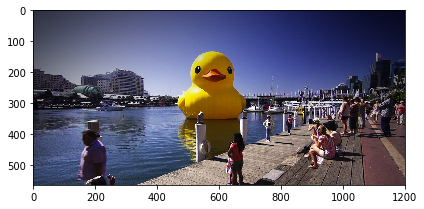

(564, 1200, 3)


In [2]:
# load the image and confirm skimage is imported properly.
image = io.imread('data/small_duck.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [3]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)

(676800, 3)


## Random centroids (15 points)

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Input: a single image of shape `(num_instances, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimentional array.
Output: Randomly chosen centroids of shape `(k,3)`.

In [4]:
def get_random_centroids(X, k):
    import random
    centroids = []
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    for i in random.sample(range(0, X.shape[0]), k):
        centroids.append(X[i])
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return centroids

In [5]:
k = 7 
centroids = get_random_centroids(image, k)
print(centroids)

[array([218, 194,  46], dtype=uint8), array([ 66,  75, 114], dtype=uint8), array([108, 100,  97], dtype=uint8), array([23, 21, 22], dtype=uint8), array([21, 15, 19], dtype=uint8), array([ 91, 105, 168], dtype=uint8), array([ 92,  96, 134], dtype=uint8)]


## Distance function (25 points)

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Implement the function `lp_distance` (=Minkoski distance).

Inputs: 
* a single image of shape `(num_instances, 3)` 
* the centroids `(k, 3)`
* the distance parameter p

output: array of shape `(k, num_instances)` thats holds the distances of all points in RGB space from all centroids

In [6]:
def lp_distance(X, centroids, p=2):
    distances = []
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    for centroid in centroids:
        val = np.power(np.sum(np.power(np.absolute(X - centroid), p), axis=1), 1/p)
        distances.append(val)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return np.array(distances)

In [7]:
distances = lp_distance(image, centroids, 5)
print(distances)

[[3.11863396 2.39621299 3.27020005 ... 2.69815694 3.04783288 3.02429467]
 [3.15377654 3.16978638 3.5129402  ... 2.63901582 3.21969861 3.56272563]
 [2.         2.74552195 2.53651748 ... 3.03143313 2.62231185 2.9081223 ]
 ...
 [3.21969861 3.51162596 2.78982744 ... 2.96719144 2.         2.86193816]
 [3.2994029  1.24573094 2.9081223  ... 2.80936139 3.60040267 2.90532064]
 [2.15983001 2.91091321 3.25252225 ... 3.4157855  3.13536803 3.2399152 ]]


## Kmeans algorithm (40 points)

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to the closest centroids and calculate new centroids by averaging the points that were assigned to every centroid. This function stops, 
when no improvement was made or once max_iter iterations passed.

A reasonable implementation runs on a Core i7 CPU in less than a minute with `k=16`.

In [8]:
def kmeans(X, k, p ,max_iter=100):
    """
    Inputs:
    - X: a single image of shape (num_features, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.
    Outpust:
    - The calculated centroids
    - The final assignment of all RGB points to the closest centroids
    """
    classes = []
    centroids = []
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    centroids = get_random_centroids(X, k)
    
    for i in range(max_iter):
        dist = lp_distance(X, centroids, p)
        newclasses = np.argmin(dist, axis=0)
        if np.array_equal(newclasses, classes): # no one changed cluster
            break
        classes = newclasses
        centroids = np.array([(np.mean(X[np.where(classes == cluster)], axis=0)) for cluster in range(k)])
        
        
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return centroids, classes

In [9]:
centroids, classes = kmeans(image, k=4, p=1, max_iter=100)

We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with some centroid. The following cell does that for you.

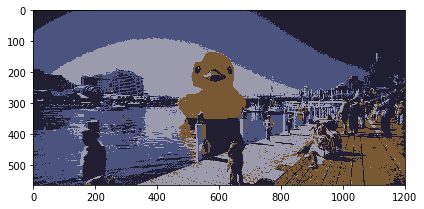

In [10]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0],classes.shape[1],3),dtype=np.uint8 )
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

## Hyper parameter tuning (20 points)

Pick 5 values for `p` and compare the results. Include both qualtitative and quantitivie analysis such as graphs, images and additional visualizations and explanations as you see fit.

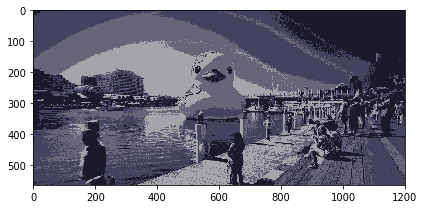

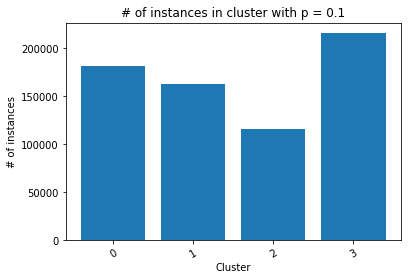

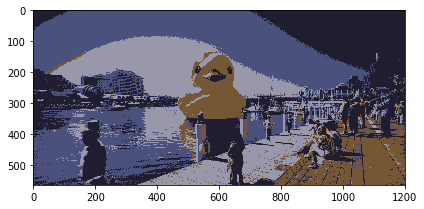

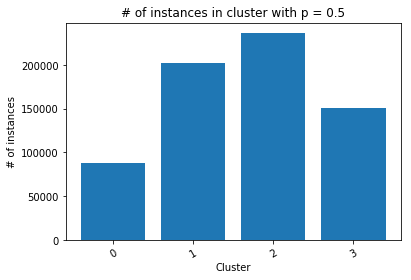

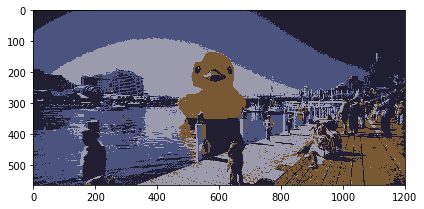

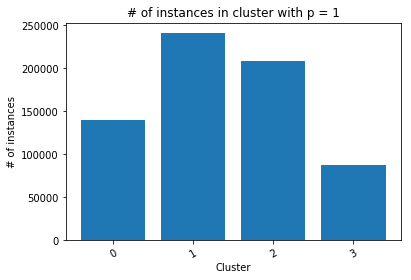

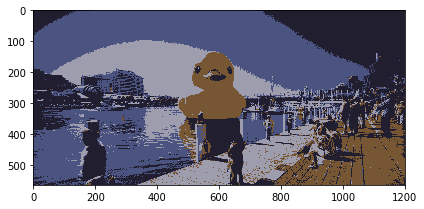

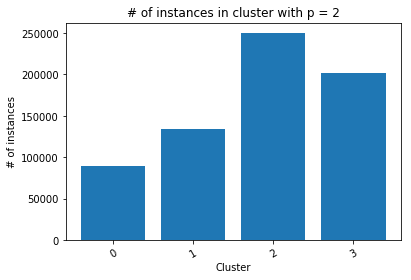

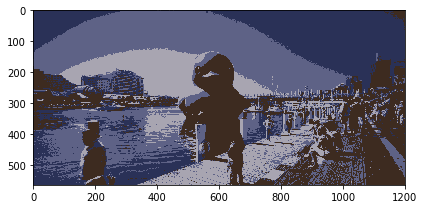

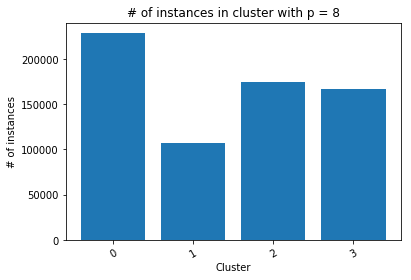

In [11]:
for p in [0.1, 0.5, 1, 2, 8]:
    centroids, classes = kmeans(image, k=4, p=p, max_iter=100)
    classes = classes.reshape(rows,cols) 
    compressed_image = np.zeros((classes.shape[0],classes.shape[1],3),dtype=np.uint8 )
    for i in range(classes.shape[0]):
        for j in range(classes.shape[1]):
                compressed_image[i,j,:] = centroids[classes[i,j],:]
    io.imshow(compressed_image)
    io.show()
    
    flat_classes = classes.flatten()
    uniq_keys = np.unique(flat_classes)
    bins = uniq_keys.searchsorted(flat_classes)
    counts = np.bincount(bins)

    index = uniq_keys
    plt.bar(index, counts)
    plt.xlabel('Cluster', fontsize=10)
    plt.ylabel('# of instances', fontsize=10)
    plt.xticks(index, fontsize=10, rotation=30)
    plt.title('# of instances in cluster with p = {}'.format(p))
    plt.show()




In [12]:
# We can see results obtained by K means algorithm using Minkowski distance metrics for 5 different values of P in the above
# images and graphes. (Notice that the result using p = 1 is the formula for Manhattan distance and for p = 2 is the formula
# for Eulidean distance)

# We can see that as the value of P increases (8), the image looks the same as for lower values of p (2), so we will focus
# on the lower p's (<=2).

# As we saw in class, K means is an algorithm that partitions the data set (of pixels in this exercise) into K clusters by
# minimizing the sum of squared distance in each cluster.
# During the implementation of K means with 5 different distance metrics (5 different P's), we notice that selection of
# distance metric (the P) plays a very important role in the clustering. So, the selection of distance metric (the P) should
# be made carefully using some thinking.

# We can see that as the value of P changes the color and the quality (distortion) of the image changes, for the good
# and for the worst.
# For some P's, the color representation is better and the distortion is less so we will choose using those P values.

# The K means, which is implemented using the P that gives us the best result compared to the original
# picture is the one that we will choose using.

# Also, we saw that large p's created more distinctly sized clusters. When we used p = [0.5 ,1, 2], the clusters are evently sized,
# while using a large p created less evenly sized clusters.